In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True' # to prevent kernel from terminating
warnings.filterwarnings('ignore')

In [2]:
data_dir = 'D:\downloads\cell_images\cell_images'

In [3]:
os.listdir(data_dir)

['test', 'train']

In [4]:
test_path = data_dir+'\\test\\'
train_path = data_dir+'\\train\\'

In [5]:
test_path

'D:\\downloads\\cell_images\\cell_images\\test\\'

In [6]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(train_path+'parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [8]:
# tell image read funct to read the image

In [9]:
para_cell = train_path+'parasitized\\'+'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [10]:
para_cell

'D:\\downloads\\cell_images\\cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

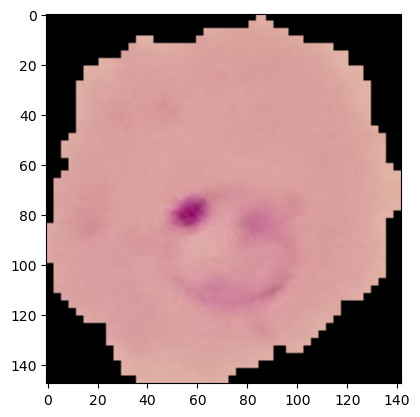

In [11]:
plt.imshow(imread(para_cell))

In [12]:
# Uninfected cell

In [13]:
uninfected_cell = train_path+'uninfected\\'+os.listdir(train_path+'uninfected')[0]

In [14]:
uninfected_cell

'D:\\downloads\\cell_images\\cell_images\\train\\uninfected\\C100P61ThinF_IMG_20150918_144104_cell_128.png'

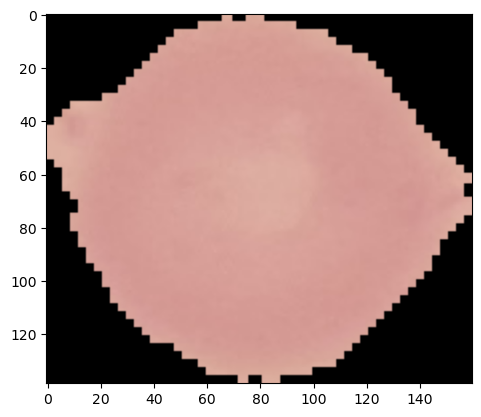

In [15]:
plt.imshow(imread(uninfected_cell))

In [16]:
# total number of parasitized cells on train set

In [17]:
len(os.listdir(train_path+'parasitized'))

12480

In [18]:
# total number of uninfected cells on train set

In [19]:
len(os.listdir(train_path+'uninfected'))

12480

In [20]:
# The average shape of the images

In [21]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path+'uninfected'):
    img = imread(test_path+'uninfected\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [22]:
##distribution of the images

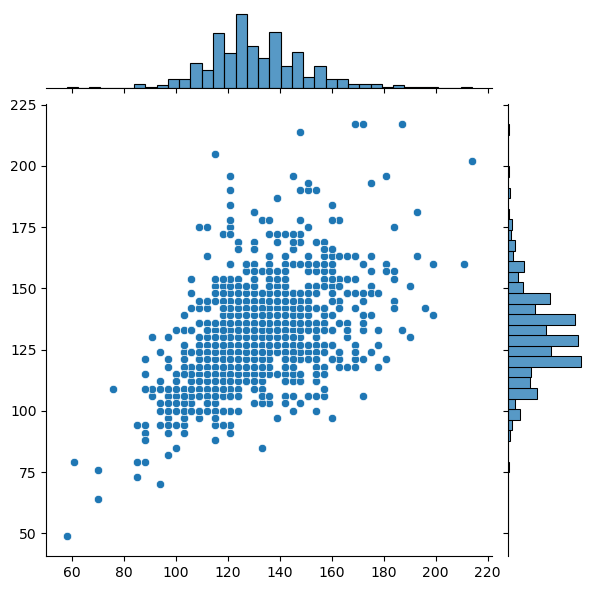

In [23]:
sns.jointplot(x=dim1,y=dim2)

In [24]:
print("the mean of image in dim1 is : ")
print(np.mean(dim1))

the mean of image in dim1 is : 
130.92538461538462


In [25]:
print("the mean of image in dim2 is : ")
print(np.mean(dim2))

the mean of image in dim2 is : 
130.75


In [26]:
img_shape = (130,130,3)

In [32]:
# Image Manipulation and Translations
## Image Data Generator

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
#help(ImageDataGenerator)

In [30]:
image_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

In [ ]:
## Checking the transformation

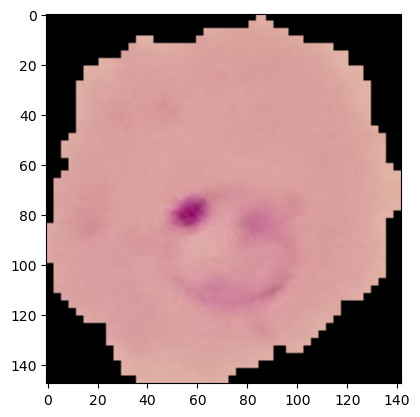

In [34]:
para_img = imread(para_cell)
plt.imshow(para_img)

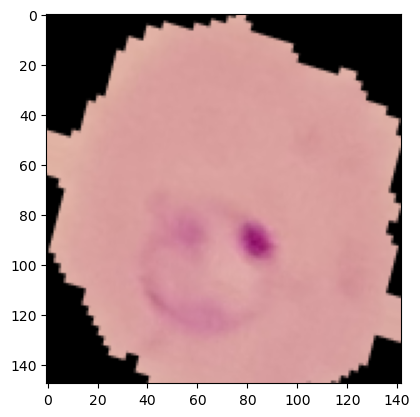

In [35]:
plt.imshow(image_gen.random_transform(para_img))

In [36]:
## Setting up the directories to flow batches from a directory

In [38]:
train_path

'D:\\downloads\\cell_images\\cell_images\\train\\'

In [39]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [40]:
# Image gen from test set

In [41]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [42]:
# Creating the model that willfit to a generator

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten

In [46]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=img_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=img_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=img_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

In [51]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [52]:
batch_size = 16

In [53]:
# Creating two generators

In [54]:
train_img_gen = image_gen.flow_from_directory(train_path,
                                             target_size=img_shape[:2],
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             class_mode='binary')

Found 24958 images belonging to 2 classes.


In [55]:
test_img_gen = image_gen.flow_from_directory(test_path,
                                             target_size=img_shape[:2],
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             class_mode='binary',
                                            shuffle=False)

Found 2600 images belonging to 2 classes.


In [56]:
train_img_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [57]:
results = model.fit_generator(train_img_gen,epochs=20,
                             validation_data=test_img_gen,
                             callbacks=[early_stop]) 

## Stopping the Training due to saving computational time 

Epoch 1/20
 283/1560 [====>.........................] - ETA: 12:33 - loss: 1.4755 - accuracy: 0.5265

KeyboardInterrupt: 

In [58]:
# Loading the already created model 

In [59]:
from tensorflow.keras.models import load_model

In [60]:
model = load_model('malaria_detector.h5')

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0